# Insurance Fraud Claims Detection

In this notebook, I'm going to engineer the variables of **Auto Insurance Claims Data** on Kaggle. 

To engineer the variables We need to tackle:

1. Missing values: Assess missing in ['collision_type', 'property_damage', 'police_report_available']
2. Target variable: Encoding
3. Numerical variables:
    - Time variables: Convert string in datetime in ['policy_bind_date', 'incident_date']
    - Discrete variables: Assess umbrella_limit variable
    - Continuous variables: Binning and Calculate capital net
4. Outliers (not now)
5. Categorical variables
    - Rare labels
    - Drop 'incident_location' and Encoding
6. Standarise the values of the variables to the same range

## Libraries and Environments

In [1]:
# Data Sciences

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# Plot

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Utils
import os
import pprint

# Set notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.simplefilter(action='ignore')

In [2]:
raw = '../data/raw/insurance_claims.csv'
interim = '../data/interim/'
processed= '../data/processed/'
models= '../models/'

## Data Preparation

### Read data

In [3]:
data = pd.read_csv(processed + 'sample.csv')
print(data.shape)
data.head()

(1000, 39)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital_gains,capital_loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

### Variables setting

In [5]:
# For semplicity I'll drop some variables.They required futhers analysis.
# Also we don't have enough class labels. We should generate syntetic records.

# 'policy_deductable', 'umbrella_limit', 'insured_hobbies',

drop = ['policy_number', 'policy_bind_date', 'policy_state', 'policy_csl', 
        'insured_zip', 'insured_occupation', 'incident_date', 
        'insured_education_level', 'insured_relationship', 'injury_claim', 'property_claim', 'vehicle_claim', 
        'incident_state', 'incident_city', 'incident_location', 'auto_model', 'auto_make', 'auto_year']

target = 'fraud_reported'

# general
predictors = [col for col in data.columns if col not in drop and col != target]

# numerical

time_predictors = [
    col for col in predictors if 'year' in col or 'date' in col]

numerical_predictors = [
    col for col in predictors if data[col].dtypes != 'object']
# time_predictors = [col for col in predictors if 'year' in col or 'date' in col]

discrete_predictors = [col for col in numerical_predictors if len(
    data[col].unique()) < 30 and col not in time_predictors]
continuous_predictors = [
    col for col in numerical_predictors if col not in discrete_predictors + time_predictors]

# non numerical
categorical_predictors = [
    col for col in predictors if data[col].dtypes == 'object' and col not in time_predictors]
ordinal_predictors = ['incident_severity']
nominal_predictors = [
    col for col in categorical_predictors if col not in ordinal_predictors and col != target]

# missing
missing_predictors = [col for col in categorical_predictors if any(
    data[col].str.contains('?', regex=False))]

In [6]:
data.drop(drop, axis=1, inplace=True)

## Feature Engineering

### Missing values

Assess missing in 'collision_type', 'property_damage' and 'police_report_available'

In [7]:
for var in missing_predictors:
    print(var)
    print(data[var].value_counts(), '\n')

collision_type
Rear Collision     292
Side Collision     276
Front Collision    254
?                  178
Name: collision_type, dtype: int64 

property_damage
?      360
NO     338
YES    302
Name: property_damage, dtype: int64 

police_report_available
NO     343
?      343
YES    314
Name: police_report_available, dtype: int64 



**Comment**: We may replace it with 'Missing' string

In [8]:
data[missing_predictors] = data[missing_predictors].replace('?', 'missing')

In [9]:
# Check
for var in missing_predictors:
    data_missing = any(data[var].str.contains('?', regex=False))
print(data_missing)

False


In [10]:
data.to_csv(interim + '0_data_missing.csv', index=False)

### Target Variable

In [11]:
data[target].unique()

array(['Y', 'N'], dtype=object)

In [12]:
target_categories = {'Y': 1, 'N': 0}

data[target] = data[target].map(target_categories).astype('category')

print(data[target].cat.categories)

Int64Index([0, 1], dtype='int64')


In [13]:
data.to_csv(interim + '1_data_target.csv', index=False)

### Numerical variables

<!-- #### Time variables
# time_to_incident_months
# data[time_predictors].info()

# for var in time_predictors:
#     if var == 'auto_year':
#     df[var] = pd.to_datetime(df[var], format='%Y')
#         pass
#     else:
#         data[var] = pd.to_datetime(data[var])
        
# print(data[time_predictors].info())

# def time_monthly_incident(data, var):
#     # Time difference
#     data['time_to_incident'] = data[var] - data['policy_bind_date']
#     data['time_to_incident_days'] = data['time_to_incident'].dt.days
#     # Monthly-based difference
#     data['time_to_incident_months'] = round(data['time_to_incident_days'] / 30, 0)
#     # Negative differences has no sense
#     flt_time = data['time_to_incident_months'] > 0
#     #Drop date variables
#     data.drop([var, 'policy_bind_date', 'time_to_incident', 'time_to_incident_days'], axis=1, inplace=True)
#     return data[flt_time]

# data = time_monthly_incident(data, 'incident_date')

# data.shape

# data.to_csv(interim + '2_data_time.csv', index=False) -->

#### Discrete Variables

In [14]:
data[discrete_predictors]

,policy_deductable,umbrella_limit,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses
0,1000,0,5,1,1,2
1,2000,5000000,8,1,0,0
2,2000,5000000,7,3,2,3
3,2000,6000000,5,1,1,2
4,1000,6000000,20,1,0,1
...,...,...,...,...,...,...
995,1000,0,20,1,0,1
996,1000,0,23,1,2,3
997,500,3000000,4,3,2,3
998,2000,5000000,2,1,0,1


**umbrella_limit**

In [15]:
print(data['umbrella_limit'].value_counts(), '\n')
data = data[data['umbrella_limit']>=0]
print(data['umbrella_limit'].value_counts(), '\n')
data.to_csv(interim + '3_data_umbrella.csv', index=False)

 0           798
 6000000      57
 5000000      46
 4000000      39
 7000000      29
 3000000      12
 8000000       8
 9000000       5
 2000000       3
 10000000      2
-1000000       1
Name: umbrella_limit, dtype: int64 

0           798
6000000      57
5000000      46
4000000      39
7000000      29
3000000      12
8000000       8
9000000       5
2000000       3
10000000      2
Name: umbrella_limit, dtype: int64 



**policy_decuctable**

In [16]:
bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']

data['policy_deductable_group'] = pd.cut(data['policy_deductable'], bins = bins, labels = bin_labels)
data.drop('policy_deductable', axis=1, inplace=True)

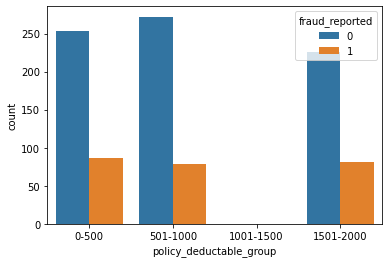

In [17]:
sns.countplot(x="policy_deductable_group", hue="fraud_reported", data=data);

In [18]:
data.to_csv(interim + '2_data_policy_deductable.csv', index=False)

#### Continuous Variables

In [19]:
data[continuous_predictors]

,months_as_customer,age,policy_annual_premium,capital_gains,capital_loss,total_claim_amount
0,328,48,1406.91,53300,0,71610
1,228,42,1197.22,0,0,5070
2,134,29,1413.14,35100,0,34650
3,256,41,1415.74,48900,-62400,63400
4,228,44,1583.91,66000,-46000,6500
...,...,...,...,...,...,...
995,3,38,1310.80,0,0,87200
996,285,41,1436.79,70900,0,108480
997,130,34,1383.49,35100,0,67500
998,458,62,1356.92,0,0,46980


**Age**

In [20]:
data['age'].describe()

count    999.000000
mean      38.944945
std        9.144354
min       19.000000
25%       32.000000
50%       38.000000
75%       44.000000
max       64.000000
Name: age, dtype: float64

In [21]:
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]

data['age_groups'] = pd.cut(data['age'], bins = bins, labels = bin_labels, include_lowest = True)
data.drop('age', axis=1, inplace=True)

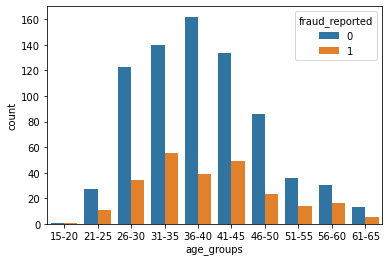

In [22]:
sns.countplot(x="age_groups", hue="fraud_reported", data=data);

In [23]:
data.to_csv(interim + '2_data_age.csv', index=False)

**policy_annual_premium**

In [24]:
data['policy_annual_premium'].describe()

count     999.000000
mean     1256.323934
std       244.275843
min       433.330000
25%      1089.185000
50%      1257.040000
75%      1415.710000
max      2047.590000
Name: policy_annual_premium, dtype: float64

In [25]:
bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']

data['policy_annual_premium_groups'] = pd.cut(data['policy_annual_premium'], bins = bins, labels=bin_labels)
data.drop('policy_annual_premium', axis=1, inplace=True)

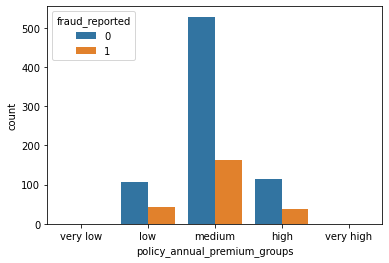

In [26]:
sns.countplot(x="policy_annual_premium_groups", hue="fraud_reported", data=data);

In [27]:
data.to_csv(interim + '3_data_annual_prem.csv', index=False)

<!-- # capital net
# data['capital_net'] = abs(data['capital_gains'] - data['capital_loss'])
# data.drop(['capital_gains', 'capital_loss'], axis=1, inplace=True)
# sns.distplot(data[data['fraud_reported']==0]['capital_net'], kde=False);
# sns.distplot(data[data['fraud_reported']==1]['capital_net'], kde=False);
# data.to_csv(interim + '6_data_capital_net.csv', index=False) -->

**months_as_customer**

In [28]:
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']

data['months_as_customer_groups'] = pd.cut(data['months_as_customer'], bins = 10, labels = bin_labels, include_lowest= True)
data.drop(['months_as_customer'], axis=1, inplace=True)

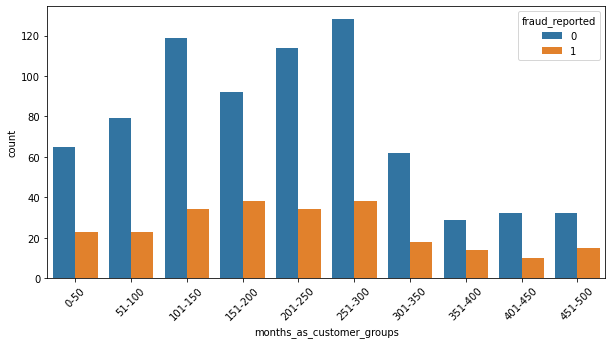

In [29]:
plt.figure(figsize=(10,5))
fig = sns.countplot(x="months_as_customer_groups", hue="fraud_reported", data=data);
fig.set_xticklabels(fig.get_xticklabels(), rotation=45);


In [30]:
data.to_csv(interim + '4_data_months_as_customer.csv', index=False)

### Categorical Variables

In [31]:
categorical_predictors = categorical_predictors + ['age_groups', 'policy_annual_premium_groups', 'policy_deductable_group']
data[categorical_predictors]

,insured_sex,insured_hobbies,incident_type,collision_type,incident_severity,authorities_contacted,property_damage,police_report_available,age_groups,policy_annual_premium_groups,policy_deductable_group
0,MALE,sleeping,Single Vehicle Collision,Side Collision,Major Damage,Police,YES,YES,46-50,medium,501-1000
1,MALE,reading,Vehicle Theft,missing,Minor Damage,Police,missing,missing,41-45,medium,1501-2000
2,FEMALE,board-games,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NO,NO,26-30,medium,1501-2000
3,FEMALE,board-games,Single Vehicle Collision,Front Collision,Major Damage,Police,missing,NO,41-45,medium,1501-2000
4,MALE,board-games,Vehicle Theft,missing,Minor Damage,None,NO,NO,41-45,high,501-1000
...,...,...,...,...,...,...,...,...,...,...,...
995,FEMALE,paintball,Single Vehicle Collision,Front Collision,Minor Damage,Fire,YES,missing,36-40,medium,501-1000
996,FEMALE,sleeping,Single Vehicle Collision,Rear Collision,Major Damage,Fire,YES,missing,41-45,medium,501-1000
997,FEMALE,bungie-jumping,Multi-vehicle Collision,Side Collision,Minor Damage,Police,missing,YES,31-35,medium,0-500
998,MALE,base-jumping,Single Vehicle Collision,Rear Collision,Major Damage,Other,missing,YES,61-65,medium,1501-2000


#### Nominal

In [32]:
nominal_predictors = nominal_predictors + ['age_groups', 'months_as_customer_groups']

In [33]:
data[nominal_predictors]

,insured_sex,insured_hobbies,incident_type,collision_type,authorities_contacted,property_damage,police_report_available,age_groups,months_as_customer_groups
0,MALE,sleeping,Single Vehicle Collision,Side Collision,Police,YES,YES,46-50,301-350
1,MALE,reading,Vehicle Theft,missing,Police,missing,missing,41-45,201-250
2,FEMALE,board-games,Multi-vehicle Collision,Rear Collision,Police,NO,NO,26-30,101-150
3,FEMALE,board-games,Single Vehicle Collision,Front Collision,Police,missing,NO,41-45,251-300
4,MALE,board-games,Vehicle Theft,missing,None,NO,NO,41-45,201-250
...,...,...,...,...,...,...,...,...,...
995,FEMALE,paintball,Single Vehicle Collision,Front Collision,Fire,YES,missing,36-40,0-50
996,FEMALE,sleeping,Single Vehicle Collision,Rear Collision,Fire,YES,missing,41-45,251-300
997,FEMALE,bungie-jumping,Multi-vehicle Collision,Side Collision,Police,missing,YES,31-35,101-150
998,MALE,base-jumping,Single Vehicle Collision,Rear Collision,Other,missing,YES,61-65,451-500


In [34]:
# **insured_hobbies**
replace_labels = [label for label in data['insured_hobbies'].unique() if label not in ['chess', 'cross-fit']]
data['insured_hobbies'] = data['insured_hobbies'].replace(replace_labels, 'others')

In [35]:
data = pd.get_dummies(data, columns=nominal_predictors)

In [36]:
data.to_csv(interim + '5_data_dummies.csv', index=False)

#### Ordinal

In [37]:
ordinal_predictors = ordinal_predictors + ['policy_annual_premium_groups', 'policy_deductable_group']
data[ordinal_predictors]

,incident_severity,policy_annual_premium_groups,policy_deductable_group
0,Major Damage,medium,501-1000
1,Minor Damage,medium,1501-2000
2,Minor Damage,medium,1501-2000
3,Major Damage,medium,1501-2000
4,Minor Damage,high,501-1000
...,...,...,...
995,Minor Damage,medium,501-1000
996,Major Damage,medium,501-1000
997,Minor Damage,medium,0-500
998,Major Damage,medium,1501-2000


In [38]:
ord_categories = {col: list(data[col].unique()) for col in ordinal_predictors}
ord_categories

{'incident_severity': ['Major Damage',
  'Minor Damage',
  'Total Loss',
  'Trivial Damage'],
 'policy_annual_premium_groups': ['medium',
  'high',
  'low',
  'very high',
  'very low'],
 'policy_deductable_group': ['501-1000', '1501-2000', '0-500']}

In [39]:
incident_severity_categories = pd.Categorical(data[ordinal_predictors]['incident_severity'],
                                              categories=['Trivial Damage',
                                                          'Minor Damage',
                                                          'Major Damage',
                                                          'Total Loss'],
                                              ordered=True)

policy_annual_premium_categories = pd.Categorical(data[ordinal_predictors]['policy_annual_premium_groups'],
                                                  categories=['very low',
                                                          'low',
                                                          'medium',
                                                          'high',
                                                          'very high'],
                                                  ordered=True)

# policy_csl_categories = pd.Categorical(data[ordinal_predictors]['policy_csl'],
#                                        categories=['100/300', '250/500', '500/1000'],
#                                        ordered=True)

policy_deductable_categories = pd.Categorical(data[ordinal_predictors]['policy_deductable_group'],
                                       categories=['0-500', '501-1000', '1001-1500', '1501-2000'],
                                       ordered=True)

In [40]:
categories = [policy_annual_premium_categories, incident_severity_categories, policy_deductable_categories]

for var, cat in zip(ord_categories, categories):
    labels, unique = pd.factorize(cat, sort=True)
    data[var] = labels

In [41]:
data

,umbrella_limit,capital_gains,capital_loss,incident_severity,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,fraud_reported,policy_deductable_group,policy_annual_premium_groups,insured_sex_FEMALE,insured_sex_MALE,insured_hobbies_chess,insured_hobbies_cross-fit,insured_hobbies_others,incident_type_Multi-vehicle Collision,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,collision_type_Front Collision,collision_type_Rear Collision,collision_type_Side Collision,collision_type_missing,authorities_contacted_Ambulance,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,property_damage_NO,property_damage_YES,property_damage_missing,police_report_available_NO,police_report_available_YES,police_report_available_missing,age_groups_15-20,age_groups_21-25,age_groups_26-30,age_groups_31-35,age_groups_36-40,age_groups_41-45,age_groups_46-50,age_groups_51-55,age_groups_56-60,age_groups_61-65,months_as_customer_groups_0-50,months_as_customer_groups_51-100,months_as_customer_groups_101-150,months_as_customer_groups_151-200,months_as_customer_groups_201-250,months_as_customer_groups_251-300,months_as_customer_groups_301-350,months_as_customer_groups_351-400,months_as_customer_groups_401-450,months_as_customer_groups_451-500
0,0,53300,0,2,5,1,1,2,71610,1,1,2,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,5000000,0,0,2,8,1,0,0,5070,1,2,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,5000000,35100,0,2,7,3,2,3,34650,0,2,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,6000000,48900,-62400,2,5,1,1,2,63400,1,2,2,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,6000000,66000,-46000,3,20,1,0,1,6500,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,2,20,1,0,1,87200,0,1,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
996,0,70900,0,2,23,1,2,3,108480,0,1,2,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
997,3000000,35100,0,2,4,3,2,3,67500,0,0,1,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
998,5000000,0,0,2,2,1,0,1,46980,0,2,2,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999 entries, 0 to 999
Data columns (total 56 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   umbrella_limit                          999 non-null    int64   
 1   capital_gains                           999 non-null    int64   
 2   capital_loss                            999 non-null    int64   
 3   incident_severity                       999 non-null    int64   
 4   incident_hour_of_the_day                999 non-null    int64   
 5   number_of_vehicles_involved             999 non-null    int64   
 6   bodily_injuries                         999 non-null    int64   
 7   witnesses                               999 non-null    int64   
 8   total_claim_amount                      999 non-null    int64   
 9   fraud_reported                          999 non-null    category
 10  policy_deductable_group                 999 non-nu

In [43]:
data.to_csv(interim + '6_data_ordinal.csv', index=False)

### Feature Scaling

In [44]:
predictors = [col for col in data.columns if col != 'fraud_reported']

In [45]:
# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(data[predictors]) 

# transform the train and test set
data[predictors] = scaler.transform(data[predictors])

In [46]:
data.to_csv(processed + 'data_final.csv', index=False)
data[predictors].to_csv(processed + 'X_final.csv', index=False)
data['fraud_reported'].to_csv(processed + 'y_final.csv', index=False)

### Train-Test splitting

In [47]:
X_train, X_test, y_train, y_test = train_test_split(data[predictors], data[target], 
                                                    test_size=0.1, 
                                                    random_state=1) # ALWAYS set random seed for reproducibility!
X_train.shape, X_test.shape

((899, 55), (100, 55))

In [48]:
X_train.to_csv(processed + 'X_train_final.csv', index=False)
X_test.to_csv(processed + 'X_test_final.csv', index=False)

In [49]:
y_train.to_csv(processed + 'y_train_final.csv', index=False)
y_test.to_csv(processed + 'y_test_final.csv', index=False)

## Final comment

At the end, I get 55 predictors for training the model